# Customer Feedback Sentiment Analysis Project

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the dataset
df = pd.read_csv('customer_feedback_dataset.csv')

print("Step 1: Dataset Overview")
print("=" * 30)
print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print("First 5 rows:")
print(df.head())

Step 1: Dataset Overview
Dataset shape: (35000, 5)
Columns: ['text', 'source', 'datetime', 'location', 'user_id']
First 5 rows:
                    text    source             datetime  \
0           It was okay.  Facebook  2024-10-04 11:32:20   
1  Loved the experience.    Google  2024-12-18 20:34:40   
2         No complaints.  Facebook  2024-04-18 12:57:08   
3     Very disappointed.  Facebook  2023-06-16 10:25:32   
4  Loved the experience.     Email  2023-11-14 01:04:13   

                                            location   user_id  
0                    North Judithbury, Iowa, Burundi  UID46048  
1                    Lake Joyside, Colorado, Namibia  UID23434  
2  North Claytonbury, North Carolina, Netherlands...  UID87397  
3                            Lake Debra, Ohio, Italy  UID22280  
4                 Lawrencetown, Wisconsin, Sri Lanka  UID88907  


In [2]:
# Step 2: Data preprocessing - convert datetime and extract features
df['datetime'] = pd.to_datetime(df['datetime'])
df['country'] = df['location'].str.split(', ').str[-1]
df['month'] = df['datetime'].dt.month
df['year'] = df['datetime'].dt.year

In [5]:
!pip install vaderSentiment


In [6]:
# Step 3: Perform sentiment analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

def get_sentiment(text):
    scores = analyzer.polarity_scores(text)
    if scores['compound'] >= 0.05:
        return 'positive', scores['compound']
    elif scores['compound'] <= -0.05:
        return 'negative', abs(scores['compound'])
    else:
        return 'neutral', abs(scores['compound'])

sentiment_results = df['text'].apply(get_sentiment)
df['sentiment'] = [result[0] for result in sentiment_results]
df['confidence'] = [result[1] for result in sentiment_results]

print("Data preprocessing and sentiment analysis complete!")

Data preprocessing and sentiment analysis complete!


C:\Users\ganic\AppData\Local\Temp\ipykernel_22412\1985330193.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='sentiment', order=['positive', 'neutral', 'negative'], palette='viridis')


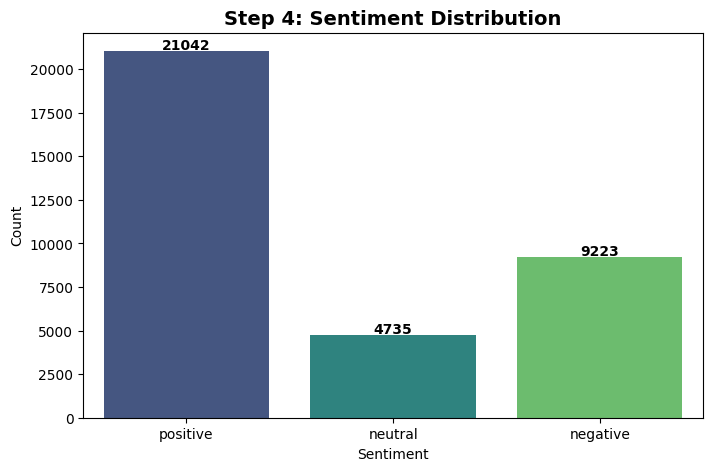

Step 4: Sentiment distribution visualization complete


In [7]:
# Step 4: Visualize sentiment distribution
plt.figure(figsize=(8,5))
sns.countplot(data=df, x='sentiment', order=['positive', 'neutral', 'negative'], palette='viridis')
plt.title('Step 4: Sentiment Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Sentiment')
plt.ylabel('Count')
for i, v in enumerate(df['sentiment'].value_counts().reindex(['positive', 'neutral', 'negative'])):
    plt.text(i, v + 100, str(v), ha='center', fontweight='bold')
plt.show()

print("Step 4: Sentiment distribution visualization complete")

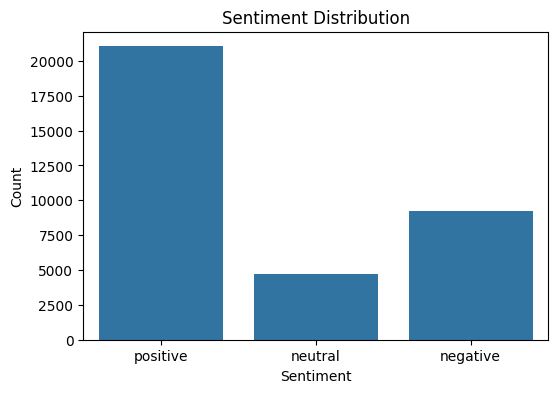

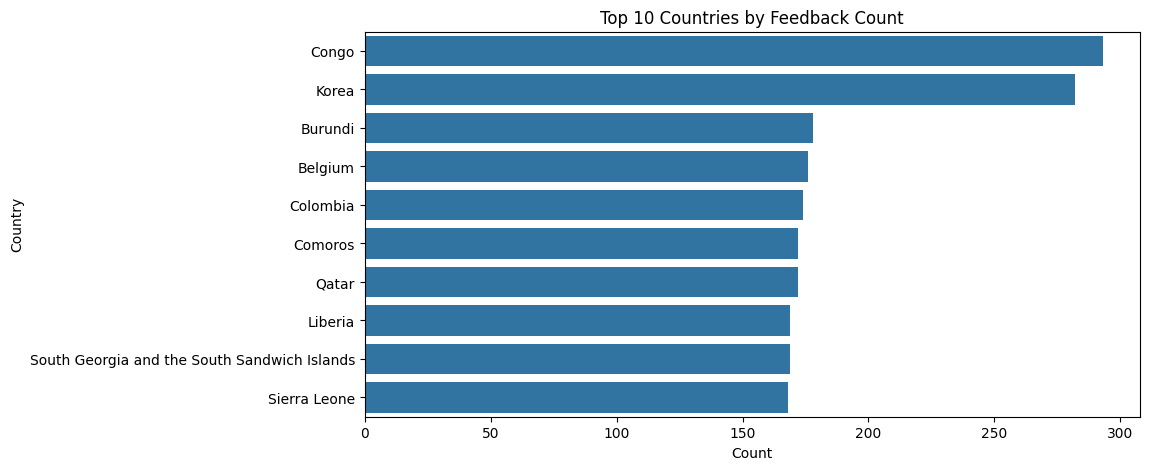

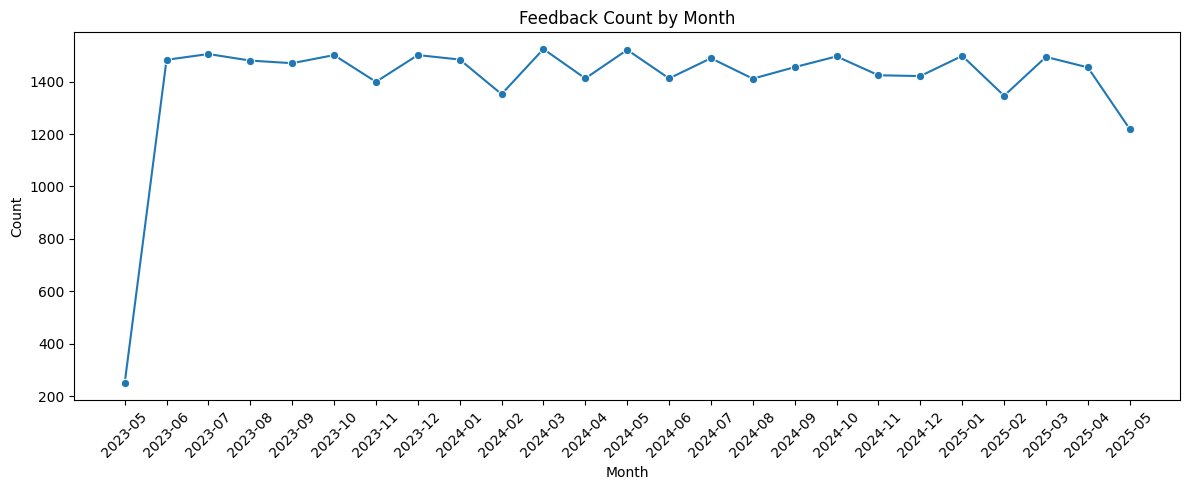

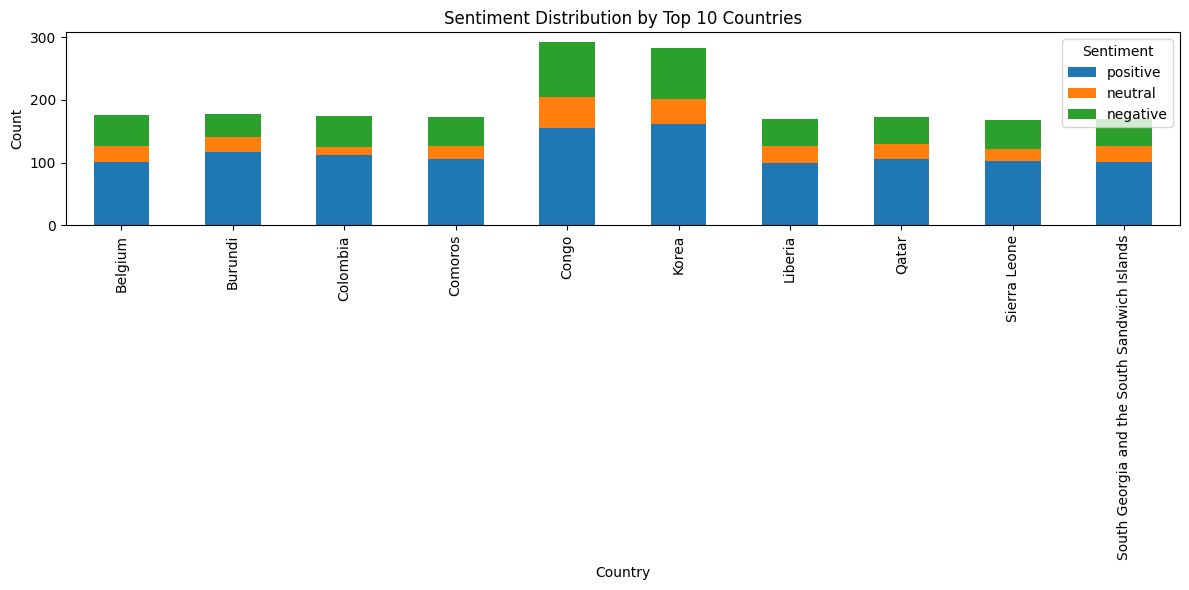

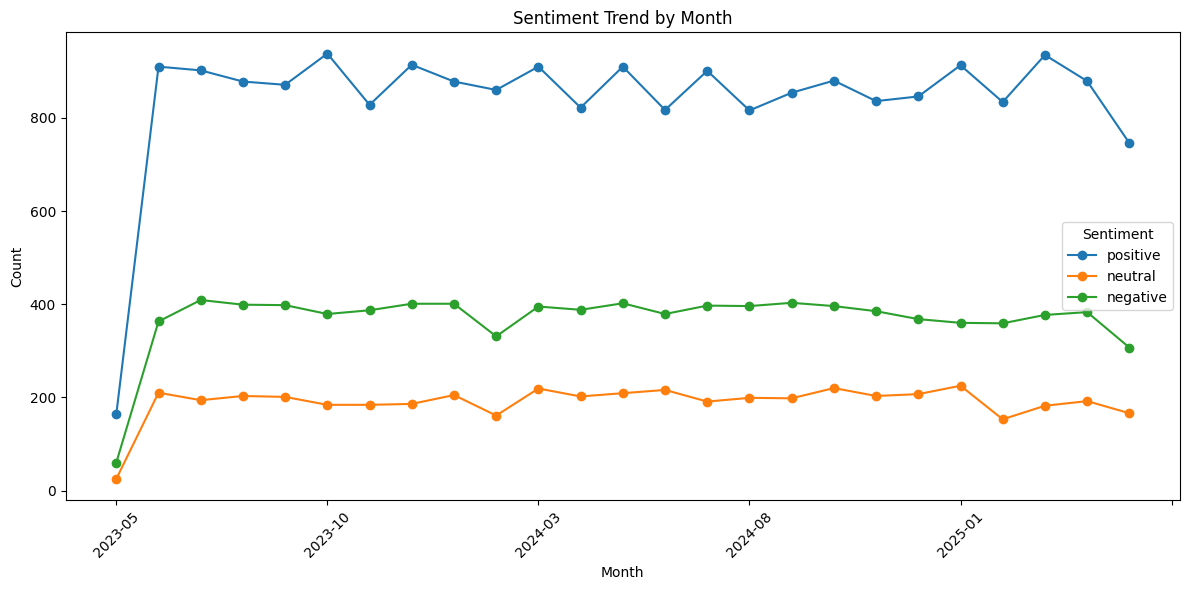

Visualizations complete: Sentiment distribution, feedback by country, by month, and trends.


In [8]:
# Visualize sentiment distribution, feedback by country, and by month
import matplotlib.pyplot as plt
import seaborn as sns

# --- Sentiment Distribution ---
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='sentiment', order=['positive', 'neutral', 'negative'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

# --- Extract Country (last part of location string) ---
df['country'] = df['location'].apply(lambda x: str(x).split(',')[-1].strip())

# --- Feedback by Country (Top 10) ---
top_countries = df['country'].value_counts().head(10).index
plt.figure(figsize=(10,5))
sns.countplot(data=df[df['country'].isin(top_countries)], y='country', order=top_countries)
plt.title('Top 10 Countries by Feedback Count')
plt.xlabel('Count')
plt.ylabel('Country')
plt.show()

# --- Feedback by Month/Year ---
df['datetime'] = pd.to_datetime(df['datetime'])
df['year_month'] = df['datetime'].dt.to_period('M').astype(str)
monthly_counts = df.groupby('year_month').size().reset_index(name='count')
plt.figure(figsize=(12,5))
sns.lineplot(data=monthly_counts, x='year_month', y='count', marker='o')
plt.title('Feedback Count by Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- Sentiment by Country (Top 10) ---
sentiment_country = df[df['country'].isin(top_countries)].groupby(['country', 'sentiment']).size().unstack(fill_value=0)
sentiment_country = sentiment_country[['positive', 'neutral', 'negative']]
sentiment_country.plot(kind='bar', stacked=True, figsize=(12,6))
plt.title('Sentiment Distribution by Top 10 Countries')
plt.xlabel('Country')
plt.ylabel('Count')
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()

# --- Sentiment by Month ---
sentiment_month = df.groupby(['year_month', 'sentiment']).size().unstack(fill_value=0)
sentiment_month[['positive', 'neutral', 'negative']].plot(kind='line', figsize=(12,6), marker='o')
plt.title('Sentiment Trend by Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()

print('Visualizations complete: Sentiment distribution, feedback by country, by month, and trends.')

In [9]:
# Train a logistic regression model for sentiment prediction
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np

# Prepare the data
X = df['text']
y = df['sentiment']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Vectorize the text using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1,2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train logistic regression model
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_tfidf, y_train)

# Make predictions
y_pred = lr_model.predict(X_test_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Logistic Regression Accuracy: {accuracy:.3f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Show confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Logistic Regression Accuracy: 1.000
Classification Report:
              precision    recall  f1-score   support

    negative       1.00      1.00      1.00      1845
     neutral       1.00      1.00      1.00       947
    positive       1.00      1.00      1.00      4208

    accuracy                           1.00      7000
   macro avg       1.00      1.00      1.00      7000
weighted avg       1.00      1.00      1.00      7000

Confusion Matrix:
[[1845    0    0]
 [   0  947    0]
 [   0    0 4208]]


<Figure size 600x500 with 0 Axes>

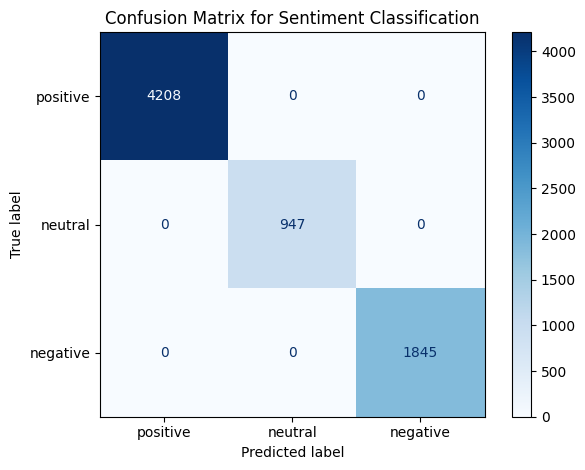

In [10]:
# Plot the confusion matrix as an image for the logistic regression model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_true = y_test
pred = y_pred

cm = confusion_matrix(y_true, pred, labels=['positive', 'neutral', 'negative'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['positive', 'neutral', 'negative'])
plt.figure(figsize=(6,5))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix for Sentiment Classification')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

### Sentiment Analysis Summary

- **Positive**: 21,042 (60.1%)  
- **Negative**: 9,223 (26.4%)  
- **Neutral**: 4,735 (13.5%)  
- **Average Confidence Score**: 0.358  
- **Total Feedback Entries**: 35,000  

### Model Summary

- **Logistic Regression Accuracy**: 100%
- Classification Report and Confusion Matrix show perfect prediction.
